<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Data Wrangling

Here we import our datasets, explore the features we have to work with, get a feel for the distributions, and do some initial cleaning.

We want to keep in mind that we have the following goals for this analysis:
- Extract Topics from the Tweet Data (Unsupervised)
- Label Emotions for each tweet (Possibly supervised)
- Establish Association between Topics and Emotions

Our Datasets:
- Climate Tweets (15m)

These tweets have already been filtered from the broader twitter stream, so this dataset includes only tweets which include either 'climate change' or 'global warming'

Data Wrangling Steps Taken:

1. Load Dataset
2. Explore raw Dataset characteristics
3. Text Preprocessing
4. Tokenization
5. Token Preprocessing




In [1]:
!pip install emoji

In [2]:
!pip install joblib

In [3]:
from google.colab import drive
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
import pandas as pd
import numpy as np
import re
import emoji

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
TWEET_TEXT_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-tweet-data.csv"
TWEET_TIMESTAMPS_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-timestamps.csv"
PREPROCESSED_TEXT_PATH = f"{DRIVE_DIR}preprocessed_text.csv"

In [6]:
# Load tweets
text_df = pd.read_csv(TWEET_TEXT_DATA_PATH)

In [7]:
# Load Timestamp Metadata
timestamps_df = pd.read_csv(TWEET_TIMESTAMPS_DATA_PATH)

In [8]:
# What is the shape of our data?
text_df.shape

(15789411, 2)

In [9]:
# What are our cols?
text_df.columns

Index(['id', 'text'], dtype='object')

In [10]:
# Is there an 'id' for each row?
text_df['id'].nunique() == text_df.shape[0]

True

In [11]:
# Ok let's use 'id' for the index
text_df.set_index('id', inplace=True)

In [12]:
# What do our tweets look like?
pd.set_option('display.max_colwidth', 300)
text_df.sample(10)

,text
id,
1121071037095923712,RT @ardenrose: I do not understand people who are AGAINST peaceful climate change protestors.. We’re trying to keep the world from becoming…
1041155800767623171,RT @MisterRudeman: Show more videos of the weather disrespecting the flag so the conservatives will want to fight climate change too https:…
737652947828375552,Meteorologists are seeing global warming's effect on the weather | Paul Douglas https://t.co/Sg8GAzIZ8M\n#ClimateChange
598281016713805824,Which one? Comparing Warren to a climate change denier or comparing Nafta to TPP? “@JasonFebery: @JesseLaGreca Not the same.”
1077812183134883841,RT @miskeencore: i have so much anxiety about climate change lol what is the point of planning for the future when at this rate we don't ha…
998508547519459329,RT @reinedelanuit05: Turnbull's energy policy fails to tackle climate change. So we've done his job for him! https://t.co/ZLxIfgH5Ll via @G…
1127414750411919361,"RT @NASAClimate: Is the 🌞 causing global warming? No. The Sun can influence Earth’s climate, but it is not responsible for the warming tren…"
1041306115571630081,"people who say regina made no effort in trying to redeem herself, never owned up to her mistakes, didn’t love henry or any other member of her family are as ignorant as people who say global warming is a myth"
3123792359,RT @CRusso815: RT @MikeyBarrz: I've never seen this before. http://tiny.cc/38b3X global warming is scary. - Where's that Dharma jumpsuit!?


In [13]:
# Ok how many duplicates do we have?
n_duplicates = text_df.duplicated().sum()
print(f"{n_duplicates} total duplicates")
print(f"{n_duplicates / text_df.shape[0] * 100}% duplicates")

6385951 total duplicates
40.444516898065416% duplicates


In [14]:
no_dupes_df = text_df.drop_duplicates()

In [15]:
# Do we have null values?
no_dupes_df.isnull().sum()

text    0
dtype: int64

<ipython-input-16-777e7e0b9bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dupes_df['text_length'] = no_dupes_df['text'].str.len()


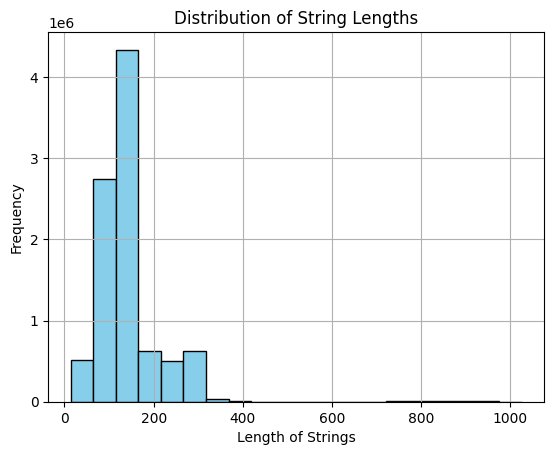

In [16]:
# What is the distribution of the length of the tweets?
# Calculate the length of each string in the 'text' column
no_dupes_df['text_length'] = no_dupes_df['text'].str.len()

# Plot the distribution of string lengths
plt.hist(no_dupes_df['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of String Lengths')
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This distribution makes sense since the original length of tweets was 140chars and then got increased to 280chars. So we see a big spike at 140 and then a tail up to 280.

In [17]:
# Merge in Timestamp Data
timestamps_df.set_index('id', inplace=True)

In [18]:
merged_df = no_dupes_df.merge(timestamps_df, left_index=True, right_index=True)

In [19]:
# What do the timestamps look like?
n_null_timestamps = merged_df['created_at'].isnull().sum()
print(f'N Null timestamps: {n_null_timestamps}')
print('Example Timestamp: ',merged_df.iloc[0]['created_at'])
print(merged_df['created_at'])

N Null timestamps: 0
Example Timestamp:  2006-06-06 16:06:42+00:00
id
6132                   2006-06-06 16:06:42+00:00
13275                  2006-07-23 21:52:30+00:00
23160                  2006-08-29 01:52:30+00:00
57868                  2006-11-07 02:46:52+00:00
304553                 2006-11-27 14:27:43+00:00
                                 ...            
1178906786792972288    2019-10-01 05:37:35+00:00
1178908472919769088    2019-10-01 05:44:17+00:00
1178908993022042112    2019-10-01 05:46:21+00:00
1178909001414610944    2019-10-01 05:46:23+00:00
1178910020626464768    2019-10-01 05:50:26+00:00
Name: created_at, Length: 9403460, dtype: object


In [20]:
# Convert 'created_at' into timestamp
merged_df['timestamp'] = pd.to_datetime(merged_df['created_at'])

In [21]:
# Group by year and count the number of rows per year
rows_per_year = merged_df.groupby(merged_df['timestamp'].dt.year).size()
print(rows_per_year)

timestamp
2006         12
2007       3597
2008      28946
2009     448153
2010     409508
2011     294049
2012     186319
2013     268237
2014     371940
2015    1206970
2016    1142734
2017    1488244
2018    2717974
2019     836777
dtype: int64


In [22]:
# Looks like the timestamps are working, so let's drop the 'created_at' str
merged_df.drop('created_at', axis=1, inplace=True)

## NLP Cleaning

At this point, having done the basic data cleanup, there is a lot of more nuanced language processing that can be done. Since we're going to be doing Topic analysis and Emotion Labelling, we can assume we're going to want to clean up the text and possibly already tokenize our strings.

### 1. Text Preprocessing

Our goal is to make the text as regular as possible and the token count (dictionary) should be as small as possible.
Some [basic text preprocessing](https://medium.com/@farhahahahahan/03-basic-text-preprocessing-nlp-90ea4469fb87) steps are:
- lowercasing
- remove html
- remove urls
- remove punctuation
- remove users
- remove hashtags (but we want to retain the actual hashtag text)
- remove emails
- remove low info chars

Some further token-based treatment that might be better done in EDA are:
- tokenization
- stopword removal
- spelling correction
- chatword translation
- handling emoji
- filtering for language (english)
- lemmatization / stemming


In [23]:
# Preprocess tweet text

def lower(text):
  return text.lower()

def remove_urls(text):
  # remove anything with a domain extension like ending
  text = re.sub(r'https?://\S+|http?://\S+', ' ', text)
  text = re.sub(r'\b\w+\.\w+\b',' ',text)
  text = re.sub(r'www\.[^\s]+', ' ', text)
  # remove words containing '://'
  text = re.sub(r'\b\S*:\/\/\S*\b', ' ', text)
  return text

def remove_html_tags(text):
  return re.sub('<.*?>', ' ', text)

def remove_user_mentions(text):
  return re.sub(r'@\w+', ' ', text)

def remove_email_addresses(text):
  return re.sub(r'\S+@\S+', ' ', text)

def remove_escape_sequences(text):
  return re.sub(r'[\r\n]+', ' ', text)

def translate_emoji(text):
  # translate emoji to text
  return emoji.demojize(text)

def remove_contraction(text):
  return re.sub(r'(?<=[a-zA-Z])\'(?=[a-zA-Z])', '', text)

def remove_low_info_chars(text):
  # remove chars that do not retain much 'meaning'
  # in this case we retain only a-z, 0-9, '!', and '?'
  return re.sub(r'[^0-9a-z\s!?]', ' ', text)

def preprocess(text):
  text = lower(text)
  text = remove_urls(text)
  text = remove_html_tags(text)
  text = remove_user_mentions(text)
  text = translate_emoji(text)
  text = remove_contraction(text)
  text = remove_escape_sequences(text)
  text = remove_low_info_chars(text)
  return text

def applyPreprocessing(sr):
  return sr.apply(preprocess)

In [24]:
# Let's test the preprocessing on a small sample
test = applyPreprocessing(merged_df['text'].sample(10000))

In [25]:
# Let's test to see if the output looks nice
# There are a lot of spaces and some of the tokens are a bit strange ie 80sf, but these are cases that can be handled on a token basis
for i, doc in enumerate(test.values[120:130]):
  print(i,doc)

0         does this have something to do with trump and his climate change post?
1    this sounds like it may have been funded by al gore  turfgrass global warming
2   ur smile   saving the global warming and the planet  globe showing  mericas 
3 the eu aims to decarbonise the power sector by 2050     climatechange  climateaction  
4  brownslastchance im all for standing up for climate change  i have one question  how took a car at some point to march today?
5 cows share the blame for global warming   ct post  
6 take action rather than tweeting about climate change      
7   so basically  dont celebrate climate change   but you may as well stop to enjoy the difference       
8 foresight isnt a human strength  global warming requires long term outlook  causes people to either not care or not act   globalwarming
9 why is the arctic experiencing social  amp  environmental changes? find out here     climatechange  climateaction  


In [26]:
# There's a strange string 'lqiq3jwcut' that might be a part of a url or something, let's investigate
# It looks like strings starting with "://" should be treated as urls also
merged_df.loc[770113887576395776]

text           American pika vanishing from western US as 'habitat lost to climate change' https://t.co/CxUZFWhQhb ://t.co/LQIq3jwcUt RT @ClimateNexus
text_length                                                                                                                                        135
timestamp                                                                                                                    2016-08-29 04:20:33+00:00
Name: 770113887576395776, dtype: object

In [27]:
# How long would it take to run the preprocessing on all ~10m tweets?
# A: Running on 100k tweets is 19s, so 10m would be 100x that... a bit long
test = applyPreprocessing(merged_df['text'].sample(100000))

In [28]:
# We only have 2 cores, we're going to need a better runtime
# Ah, the GPU100 env has 8-12 cores, much better!

In [ ]:
# Both of these took around 20s to run, something is not right with the parallelization
# How many cores do we have?
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores available:", num_cores)

In [ ]:
# Apply the function to each row of the DataFrame in parallel
# Runtime here is 4mins for the ~10m rows

# Define a function to apply preprocessing to each element of the Series in parallel
def apply_preprocessing_parallel(sr):
    n_jobs = -1 # use all cores
    return Parallel(n_jobs=n_jobs)(delayed(preprocess)(text) for text in sr)

preprocessed_texts = apply_preprocessing_parallel(merged_df['text'])

In [ ]:
# Tokenization

def handle_punctuation(text):
  # We want to buffer '!' and '?' with whitespace to treat them as tokens
  return text.replace('!', ' ! ').replace('?', ' ? ')

def tokenize(text):
  # We use the most basic tokenization approach, splitting by whitespace
  # this is reasonable since we've preprocessed all the punctuation and formatting
  return [token.strip() for token in text.split()]

def applyTokenization(sr):
  return sr.apply(handle_punctuation).apply(tokenize)

In [ ]:
# Apply Tokenization
# runtime(100k)=1.23s so we would expect runtime(10m)=123s
%%time
tokens_sr = applyTokenization(merged_df['preprocessed'])
print(f'Tokenized {len(tokens_sr)} rows')

In [ ]:
# Check to make sure Tokenization went as expected
# The tokens look well formed, but there are definitely tokens that we want to clean
pd.set_option('display.max_colwidth', None)
tokens_sr.sample(10)

In [ ]:
# Process Tokens




In [ ]:
merged_df['preprocessed'] = preprocessed_texts

In [ ]:
merged_df.info()

In [ ]:
merged_df.drop(columns=['text_length'], inplace=True)

In [ ]:
# Tokenization
# Now that we've preprocessed out text, we want to tokenize it and explore what our token-space looks like

def handle_punctuation(text):
  # We want to buffer '!' and '?' with whitespace to treat them as tokens
  return text.replace('!', ' ! ').replace('?', ' ? ')

def tokenize(text):
  # We use the most basic tokenization approach, splitting by whitespace
  # this is reasonable since we've preprocessed all the punctuation and formatting
  return [token.strip() for token in text.split()]

def applyTokenization(sr):
  return sr.apply(handle_punctuation).apply(tokenize)

In [ ]:
# Apply Tokenization
# runtime(100k)=1.23s so we would expect runtime(10m)=123s
%%time
sample_size=100000
tokens_sr = applyTokenization(merged_df['preprocessed'])
print(f'Tokenized {len(tokens)} rows')

In [ ]:
# Check to make sure Tokenization went as expected
# The tokens look well formed, but there are definitely tokens that we want to clean
pd.set_option('display.max_colwidth', None)
tokens_sr.sample(10)

In [ ]:
# What is the distribution of our tokens?
n_rows = 100000
all_tokens_list = sum(tokens_sr.tolist()[:n_rows], [])
freq_dist = FreqDist(all_tokens_list)
print(freq_dist)

In [ ]:
# Process Tokens
# Here we want to

In [ ]:
# Save preprocessed DF
merged_df.to_csv(PREPROCESSED_TEXT_PATH, index=True)